RIBBIT Application Demonstration
=================================

This notebook processes a few sample audio files to detect potential frog calls using the signal processing algorithm RIBBIT, implemented using OpenSoundscape (Lapp et al., 2021; Lapp et al., 2023). The pipeline in this Notebook consists of:

    1. Loading the audio file.
    2. Reducing background noise by a set proportion with NoiseReduce (Sainburg et al., 2020).
    3. Generating a spectrogram and analyzing it with RIBBIT using predefined species parameters.
    5. Saving the output scores as CSV files in an output folder.
    6. Reviewing top clips from a sample file by viewing their spectrograms and listening to the audio.

The current settings are tailored for the variable harlequin toad _Atelopus varius_:
- Possible pulse rate range: 120–150 pulses/second
- Signal frequency band: 1500–2500 Hz
- Clip duration for analysis: 0.5 seconds
- Frequency bands to subtract due to noise: 0–1000 Hz & 3500–4000 Hz

These values can and should be adjusted for new target species.

In [80]:
# First, we import libraries needed to run this notebook!
import time
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import noisereduce as nr
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.ribbit import ribbit
import IPython.display as ipd

In [81]:
# Define the output directory where results will be saved
OUTPUT_DIR = Path("sample_scores/ribbit")
OUTPUT_DIR.mkdir(exist_ok=True)

# Species-specific detection parameters (for Atelopus varius)
SPECIES_PARAMS = {
    "avar": {
        "pulse_rate_range": [120, 150],       # Expected pulse rate range (pulses per second)
        "signal_band": [1500, 2500],          # Frequency range (Hz) of the frog call
        "clip_duration": 0.5,                 # Duration (in seconds) for each analyzed clip
        "noise_bands": [[0, 1000], [3500, 4000]]  # Frequency ranges (Hz) expected to have noise
    }
}

# Proportion to denoise by (for more information see Sainburg et al. (2020))
PROP_DENOISE = 0.98

In [82]:
def analyze_audio_clip(file_path):
    """
    Process a single audio file:
        - Apply noise reduction.
        - Generate a spectrogram.
        - Score the spectrogram using the 'ribbit' algorithm based on species parameters.
        - Save the results as a CSV file in the output directory.
    
    Parameters:
        file_path (str or Path): Path to the audio file.
    
    Returns:
        tuple: (max_score, file_path) where max_score is the maximum ribbit score calculated.
    """
    file_path = Path(file_path)
    filename_stem = file_path.stem
    # The output CSV filename will be the audio filename with a suffix
    score_file = OUTPUT_DIR / f"{filename_stem}_ribbit_scores.csv"
    
    try:
        # Load the audio file and resample to 22050 Hz
        audio = Audio.from_file(file_path, sample_rate=22050)
        # Denoise the audio
        denoised_samples = nr.reduce_noise(y=audio.samples, 
                                           sr=audio.sample_rate, 
                                           prop_decrease=PROP_DENOISE, 
                                           n_jobs=1)
        # Recreate Audio object with the denoised samples
        denoised_audio = Audio(samples=denoised_samples, sample_rate=22050)
        # Generate a spectrogram from the denoised audio to run analysis on it
        spec = Spectrogram.from_audio(denoised_audio, window_samples=32, overlap_samples=16)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan, np.nan, str(file_path)
    
    # Calculate ribbit scores for the spectrogram with our defined species parameters
    score_list = []
    for species, params in SPECIES_PARAMS.items():
        score_df = ribbit(
            spec,
            pulse_rate_range=params["pulse_rate_range"],
            signal_band=params["signal_band"],
            clip_duration=params["clip_duration"],
            noise_bands=params["noise_bands"],
            plot=False
        )
        score_list.append(score_df)
    
    combined_scores = pd.concat(score_list)
    combined_scores["file"] = str(file_path)
    combined_scores.to_csv(score_file)
    
    # Return the maximum score found in the current file
    max_score = combined_scores["score"].max()
    # Find the index of that row with the maximum score
    max_index = combined_scores["score"].idxmax()
    # Extract the start time associated with the max score
    max_start_time = combined_scores.loc[max_index, "start_time"]
    
    return max_score, max_start_time, str(file_path), combined_scores

In [83]:
def get_sample_audio_files(media_dir="sample_audio", max_files=3):
    """
    Retrieve up to a specified number of .wav audio files from the media directory.
    
    Parameters:
        media_dir (str): Base directory where sample media files are located.
        max_files (int): Maximum number of audio files to retrieve.
    
    Returns:
        list: List of Path objects for each audio file.
    """
    media_path = Path(media_dir)
    # Recursively search for .wav files in the media directory
    audio_files = list(media_path.glob("**/*.wav"))
    return audio_files[:max_files]

In [84]:
# ===================== MAIN PROCESS ============================
# Start timer
start_time = time.time()

# Retrieve sample audio file (adjust max_files value for multiple files)
sample_audio_files = get_sample_audio_files(max_files=1)
print(f"Found {len(sample_audio_files)} sample audio file(s).")

# Process each sample audio file
results = []
for audio_file in sample_audio_files:
    score, start_time, file_processed, full_score_df = analyze_audio_clip(audio_file)
    # End time is equivalent to start time + clip duration (here, 0.5s).
    results.append((file_processed, start_time, 
                    start_time+SPECIES_PARAMS["avar"]["clip_duration"], score))
    print(f"Processed {file_processed} with max score {score} at {start_time} seconds.")

# Compile results into a DataFrame and save as a CSV
results_df = pd.DataFrame(results, columns=["file", "start_time", "end_time", "score"])
results_csv_path = OUTPUT_DIR / "sample_audio_ribbit_scores.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

end_time = time.time()
print(f"Total run time: {end_time - start_time:.2f} seconds.")


Found 1 sample audio file(s).
Processed sample_audio/test_dset_2.wav with max score 3.146489181915095e-07 at 1.0 seconds.
Results saved to sample_scores/ribbit/sample_audio_ribbit_scores.csv
Total run time: 1744316231.70 seconds.


## Investigate top-scoring clips from the last audio

In [85]:
# To better "see" the call, we extend the clip by 0.5s in the beginning and at the end.
display_clip_duration = SPECIES_PARAMS["avar"]["clip_duration"] + 1

def display_results(result_tuple, play_audio=True):
    """
    - Calculate and plot the spectrogram of the audio clip selected for review.
    - Report relevant information about the clip, including its RIBBIT score.
    - If desired, listen to the audio clip.
    """
    print(f"Displaying audio file: {result_tuple[0]} at {result_tuple[1]} seconds:")
    # Load in desired audio clip (0.5s before true start time)
    audio = Audio.from_file(result_tuple[0], 
                            offset=result_tuple[1]-0.5, 
                            duration=display_clip_duration)
    # Display spectrogram from our audio clip
    Spectrogram.from_audio(
        audio,
        window_samples=256,
        overlap_fraction=.9
    ).bandpass(0,5000).plot()
    # Play audio! :)
    if play_audio:
        ipd.display(ipd.Audio(audio.samples,rate=audio.sample_rate,autoplay=False))
    print(f"This clip got a scaled score of {result_tuple[2]*10000}.\n\n")

Displaying audio file: sample_audio/test_dset_2.wav at 1.0 seconds:


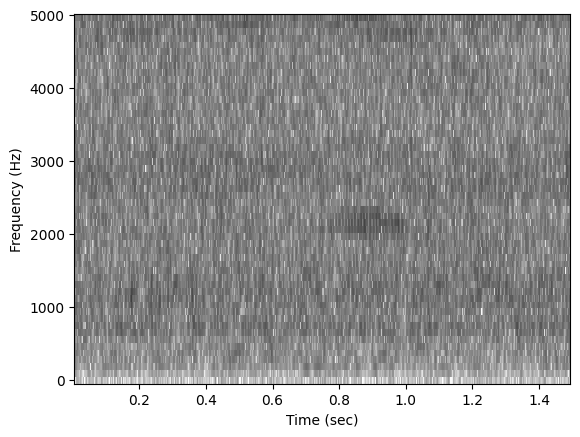

This clip got a scaled score of 0.003146489181915095.


Displaying audio file: sample_audio/test_dset_2.wav at 10.0 seconds:


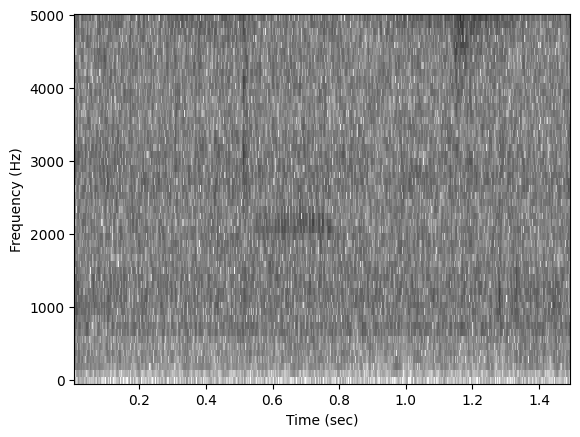

This clip got a scaled score of 0.0030708439649133603.


Displaying audio file: sample_audio/test_dset_2.wav at 59.0 seconds:


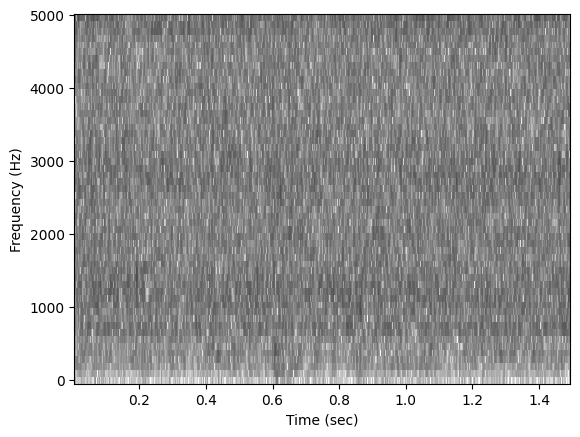

This clip got a scaled score of 0.0013502002110819887.




In [86]:
"""
Take a closer look at our last score DataFrame to display a desired 
number of highest-scoring clips from the latest file analyzed.
"""
# Set desired number of review clips.
n_review_clips = 3
# Subset DataFrame to that number of high-scoring clips.
clips_to_review = full_score_df.sort_values(by="score", ascending=False).head(n_review_clips)
# Check out your results!
for index, row in clips_to_review.iterrows():
    display_results(tuple(row[["file","start_time","score"]]), play_audio=True)